In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
from utils import ECDF
from data import load_kruschke

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

# Bayesian comparison of two (or more) groups

Comparison of two groups is a ubiquitous inference task. You'll find it in many places:

- Experimental biologists have a control group and some treatment.
- Marketers call this A/B testing.
- In clinical research, we'll have a case and control group, in which the case group receives an intervention. 

In this notebook, we will be introducing the use of PyMC3, a probabilistic programming language for Bayesian statistical modelling, and we will show how you can use PyMC3 to perform inference on this common statistical task.

This notebook will be more guided than the latter ones, to help you get familiar with the syntax.

## Problem 1: The Intervention-IQ Problem

### Data Credits

The data for this exercise was obtained from John Kruschke's paper, [Bayesian Estimation supersedes the T-test][best]. The data come from a fictional study of a drug and its effect on IQ, and have been slightly modified for pedagogical reasons.

[best]: http://www.indiana.edu/~kruschke/BEST/BEST.pdf

### Setup

You are consulting for an academic research group, which would like to independently evaluate whether an intervention boosts IQ or not. To investigate this problem, the research group has set up a case-control study, comparing the IQ of students with and without the intervention. 

### Step 1: Define Data Generating Process

Without looking at the data, let us first think about the generative model for the data. 

Generative models, you might ask?

A generative model is not necessarily a mechanistic model, in which every last detail is captured. Rather, a generative model lets us use probability distributions to express how the data were generated.

One strategy for the data generating process is to go forward from first principles. This tends to be more mechanistic and principled, particularly when we are modelling a physical system or a known process.

The other strategy is to go backwards from what the data might look like. This is useful when we do not have all of the necessary details, and is a flexible way to approximate how our data were generated. 

For this particular problem, we will take the latter strategy. 

#### Intervention IQ Data Generating Process

The data generating process for this problem may be specified as such:

1. We know that the IQ can be approximately modelled by normal distributions. 
    1. Because interventions in humans are generally expensive, we typically take few samples. Thus, instead of a normal distribution, which makes strong assumptions about having skinny tails (low probability mass in the extremes), we might want its more flexible cousin, the t-distribution. 
    1. This forms the **likelihood function** for the data.
1. The t-distribution is parameterized by three parameters:
    1. Mean
    1. Variance (or standard deviation)
    1. Degrees of Freedom (DoF)
1. It is for these data parameters for which we require **priors**. 
    1. Mean: Assuming no good prior information, it is common to use a relatively wide normal distribution: $\mu \sim N(0, 100)$
    1. Variance: Should be positive. Assuming no prior information, use a relatively flat positive distribution: $\sigma \sim HalfCauchy(100)$
    1. Degrees of Freedom ($\nu$): Should be positive and not equal to zero. We know some properties of DoF: when degrees of freedom is equal to 1, the t-distribution is equivalent to a Cauchy distribution, and as degrees of freedom go to infinity, the t-distribution becomes more and more like a Normal distribution.
        1. This is a nuisance parameter - we need it for modelling with the t-distribution, but we don't really care about it .
        1. [Questions have been asked][stats_exchange] regarding what are good priors. Check out [this link][stats_exchange] for more information.
        1. Therefore, just as with the other parameters, we can assign a fairly flat degree of freedom parameter, and let the data speak for itself.
        
        
[stats_exchange]: https://stats.stackexchange.com/questions/6492/whats-a-good-prior-distribution-for-degrees-of-freedom-in-a-t-distribution

With this setup, we have *explicitly stated our assumptions* about what we believe about the data generating process, prior to having seen any data.

In pictures, that big chunk of bullet points above can be visualized as follows:

![](../images/kruschke_model.jpg)

### Step 2: Explore the Data

Now that we have a first-pass generative model for the data, let's do some quick sanity checks against the data.

Let's get started by loading the data!

In [2]:
df = load_kruschke()
df.sample(5)

,treatment,iq,treatment_enc
1,drug,110.0,0
82,placebo,102.0,1
86,placebo,99.0,1
62,placebo,102.0,1
69,placebo,98.0,1


In [3]:
df.shape

(89, 3)

**Exercise:** Plot the number of samples for drug and for treatment.

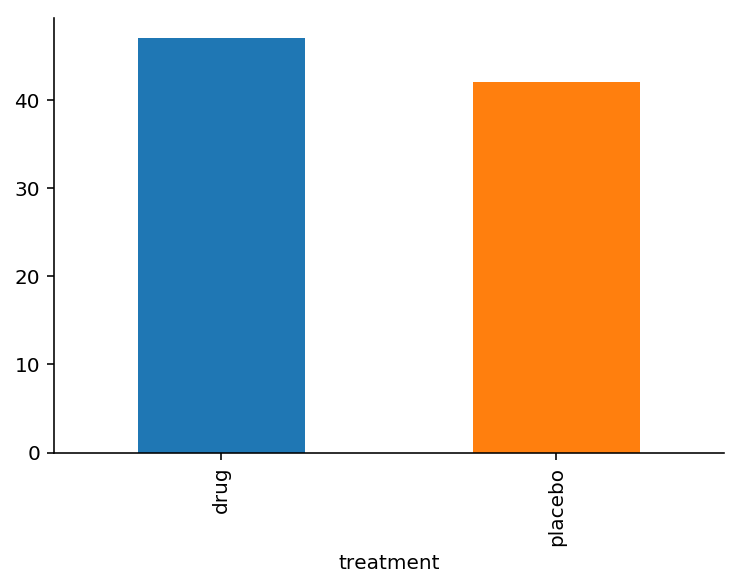

In [4]:
df.groupby('treatment').size().plot(kind='bar');  # blank out "treatment"

More important than the number of samples per treatment is the distribution of IQ, which will give us a hint as to whether we can expect a difference in effect.

**Exercise:** Plot the ECDF of the treatments vs. control. If you need to inspect the source code of ECDF, it is available below.

In [5]:
ECDF??

Signature: ECDF(data)
Docstring: <no docstring>
Source:   
def ECDF(data):
    x = np.sort(data)
    y = np.cumsum(x) / np.sum(x)
    
    return x, y
File:      ~/Documents/GitHub/bayesian-stats-modelling-tutorial/notebooks/utils.py
Type:      function


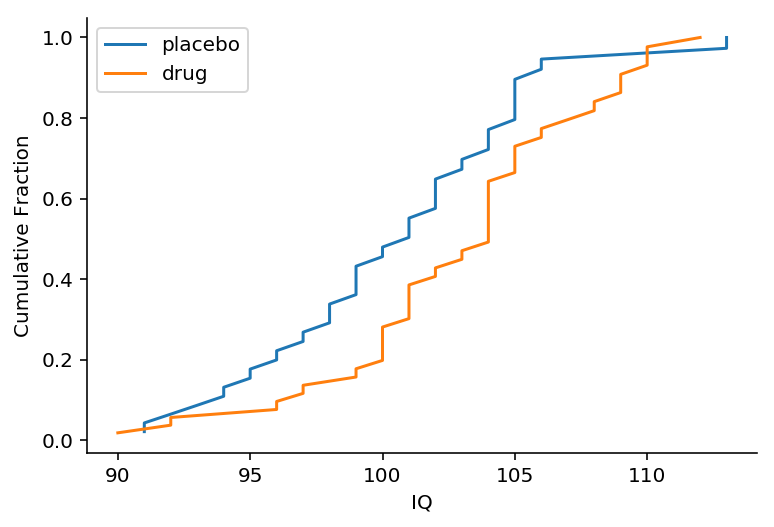

In [6]:
placebo_filter = df['treatment'] == 'placebo'
drug_filter = df['treatment'] == 'drug'

fig, ax = plt.subplots(nrows=1, ncols=1)
x_ctrl, y_ctrl = ECDF(df[placebo_filter]['iq'])
x_treat, y_treat = ECDF(df[drug_filter]['iq'])

ax.plot(x_ctrl, y_ctrl, label='placebo')
ax.plot(x_treat, y_treat, label='drug')
ax.set_xlabel('IQ')
ax.set_ylabel('Cumulative Fraction')
ax.legend();

**Discuss:** Does it look like the treatment had an effect on the IQ of the participants? What numbers from the chart above can help support your conclusions?

### Step 3: Fit Model

**Exercise:** We will specify the model below. Fill in the distributions as we go along in class. We are proceeding slowly here, simply to give you repetition practice with PyMC3's syntax.

In [7]:
with pm.Model() as kruschke_model:
    
    # Prior for drug-treated IQ mean.
    mu_drug = pm.Normal('mu_drug', mu=0, sd=100**2)
    # Prior for placebo-treated IQ mean.
    mu_placebo = pm.Normal('mu_placebo', mu=0, sd=100**2)
    
    # Prior for drug treated IQ standard deviation.
    sigma_drug = pm.HalfCauchy('sigma_drug', beta=100)
    # Prior for placebo treated IQ standard deviation.
    sigma_placebo = pm.HalfCauchy('sigma_placebo', beta=100)
    
    # Prior for nuisance parameter. Adding a small positive number 
    # guarantees that we never get nu == 0 by accident 
    # (e.g. through rounding error).
    nu = pm.Exponential('nu', lam=1/29) + 1
    
    # Likelihood function for the drug-treated participants' IQ.
    drug_like = pm.StudentT('drug', nu=nu, mu=mu_drug, 
                            sd=sigma_drug, observed=df[drug_filter]['iq'])
    
    # Likelihood function for the placebo-treated participants' IQ.
    placebo_like = pm.StudentT('placebo', nu=nu, mu=mu_placebo, 
                               sd=sigma_placebo, observed=df[placebo_filter]['iq'])
    
    # Calculate the effect size and its uncertainty.
    diff_means = pm.Deterministic('diff_means', mu_drug - mu_placebo)
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(
                                     (np.power(sigma_drug, 2) + np.power(sigma_placebo, 2)) / 2
                                  )
                                 )
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

A few pointers to help you read the code.

PyMC3 distributions are implemented using Distribution objects. Their object names match their distribution names. This is a very nice implementation detail of PyMC3! Additionally, [the docs][pymc3] show the parameters that are accepted; occasionally, the default parameterization might differ from what you have seen before, so referring to the docs is very important. 

[pymc3]: http://docs.pymc.io

`pm.Deterministic` allows us to compute a deterministic transform on the random variables. Wrapping this in a Deterministic object allows us to hook the result of the transformation into the tools used later for visualizing posterior distributions.

Now, we hit the Inference Button!

In [8]:
with kruschke_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sigma_placebo, sigma_drug, mu_placebo, mu_drug]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:11<00:00, 442.53draws/s]


Let's visualize the posterior distribution.

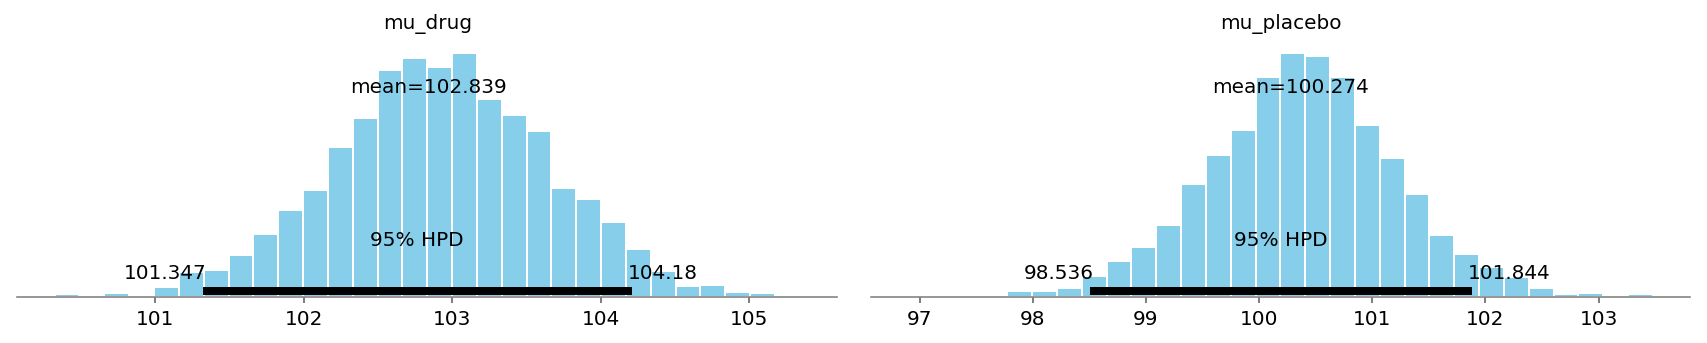

In [9]:
pm.plot_posterior(trace, varnames=['mu_drug', 'mu_placebo']);

### Step 4: Evaluate Model

We use posterior predictive checks (PPC) as one tool in our toolkit to evaluate and critique the model. The overarching goal of the PPC is to check that the data generating model generates simulated data that matches closely to the actual data. If this is the case, then we have a model that probably describes the data generating process well. If this is not the case, then we have evidence to go guide us towards re-doing the model.

**Exercise:** To do a PPC, PyMC3 provides a `sample_ppc` function, which allows us to draw samples from the posterior distribution as a check. Run the following cell, filling in the appropriate `trace` and `model`.

In [10]:
samples = pm.sample_ppc(trace=trace, samples=500, model=kruschke_model)

100%|██████████| 500/500 [00:01<00:00, 357.51it/s]


**Exercise:** Let's now plot the ECDF of the sampled data against the original data.

In [11]:
samples['drug'].shape

(500, 47)

In [12]:
# select a column for an array
def column(matrix, i):
    return [row[i] for row in matrix]

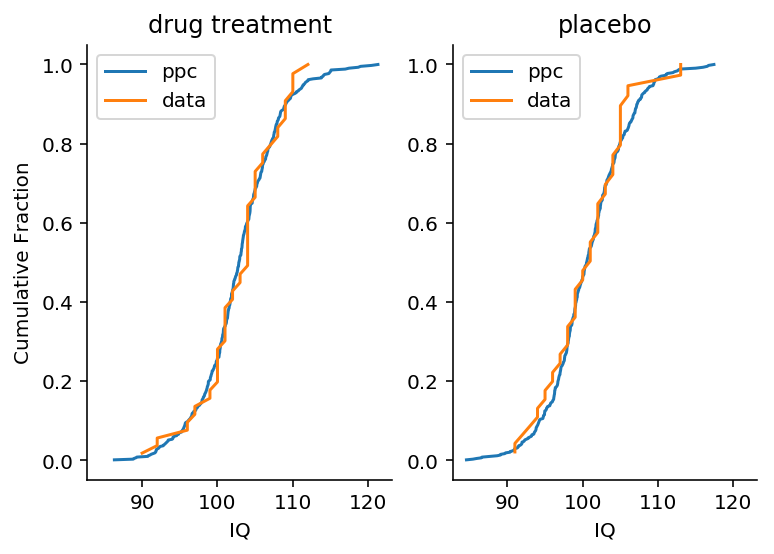

In [13]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharex=True)

x, y = ECDF(column(samples['drug'], 1))  # Want ECDF of drug-treatment PPC samples
ax1.plot(x, y, label='ppc')
x, y = ECDF(df[drug_filter]['iq'])  # Want ECDF of drug-treatment data
ax1.plot(x, y, label='data')
ax1.legend()
ax1.set_title('drug treatment')
ax1.set_xlabel('IQ')
ax1.set_ylabel('Cumulative Fraction')

x, y = ECDF(column(samples['placebo'], 1))  # Want ECDF of placebo-treatment PPC samples
ax2.plot(x, y, label='ppc')
x, y = ECDF(df[placebo_filter]['iq'])  # Want ECDF of placebo-treatment data
ax2.plot(x, y, label='data')
ax2.legend()
ax2.set_title('placebo')
ax2.set_xlabel('IQ');

It looks like we have a model that, just by eyeballing the charts, models pretty well the distribution of the observed data.

For pedagogical brevity, we did not dive into a case where the model was plausibly but nonetheless incorrectly specified. Under an incorrect model, we would expect the PPC and data distributions to be anywhere from moderately to wildly off. Having detected this from a visual comparison of the PPC samples and data, we would go back and try to see where we went wrong. We might also opt to quantify this difference using the tools provided in PyMC3. 

**Exercise:** Now, let us evaluate whether the drug actually did have an effect. Recall that we computed the difference in means, as well as an effect size, both with uncertainty. Using this information, plot the posterior distribution of the difference in means and effect sizes.

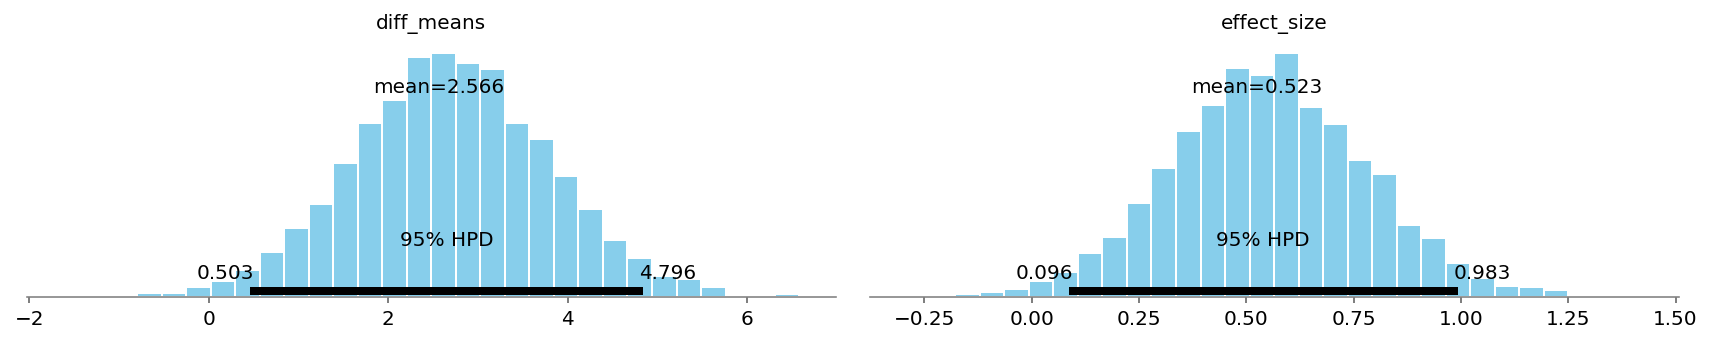

In [14]:
pm.plot_posterior(trace=trace, varnames=['diff_means', 'effect_size']);

Questions:

1. What is the 95% highest posterior density (HPD) interval for the difference of means?
1. What is the 95% HPD interval for the effect size?

**Exercise:** Compute the p-value of the t-test for this dataset.

In [15]:
from scipy.stats import ttest_ind

ttest_ind(df[placebo_filter]['iq'], df[drug_filter]['iq'], equal_var=False)

Ttest_indResult(statistic=-2.2756936448780114, pvalue=0.025378475627288653)

**Discuss**:
1. Is there a significant difference between the drug-treated and placebo-treated participants of the intervention? (This question is intentionally vague on the definition of "significant", to encourage discussion of the difference between statistical and practical significance.)
1. Would you recommend the intervention as a method to raise people's IQ? How much money would you be willing to pay for this intervention?

## Further Reading/Watching

- PyMC3's documentation contains an example of how to do [model selection][model_selection], which we did not touch on here. 
- John Kruschke's paper on [Bayesian Estimation][bayes_est] is what this notebook's example is based on. There is also a [YouTube video][bayes_yt] available.

[model_selection]: https://docs.pymc.io/notebooks/GLM-model-selection.html
[bayes_est]: http://www.indiana.edu/~kruschke/BEST/BEST.pdf
[bayes_yt]: https://www.youtube.com/watch?v=fhw1j1Ru2i0

## Alternative Syntax

There is an alternative syntax that can be used, one that takes advantage of numpy-like fancy indexing. See it below:

In [16]:
with pm.Model() as kruschke_model_alt:
    
    # We have two mus, therefor we have a vector of distributions of shape (2,).
    # Likewise for sds.
    mus = pm.Normal('mu', mu=0, sd=100**2, shape=(2,))
    sds = pm.HalfCauchy('sigma', beta=100, shape=(2,))
    
    # Prior for nuisance parameter. Adding a small positive number 
    # guarantees that we never get nu == 0 by accident 
    # (e.g. through rounding error).
    nu = pm.Exponential('nu', lam=1/29) + 1
    
    # Likelihood function for the IQ values.
    # Fancy indexing allows us 
    likelihood = pm.StudentT('likelihood', nu=nu, mu=mus[df['treatment_enc']], 
                             sd=sds[df['treatment_enc']], observed=df['iq'])
    
    # Calculate the effect size and its uncertainty.
    diff_means = pm.Deterministic('diff_means', mus[0] - mus[1])
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(np.power(sds[0], 2) + 
                                         np.power(sds[1], 2) / 2))
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

In [17]:
with kruschke_model_alt:
    trace_alt = pm.sample(2000, tuning=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sigma, mu]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:16<00:00, 304.16draws/s]


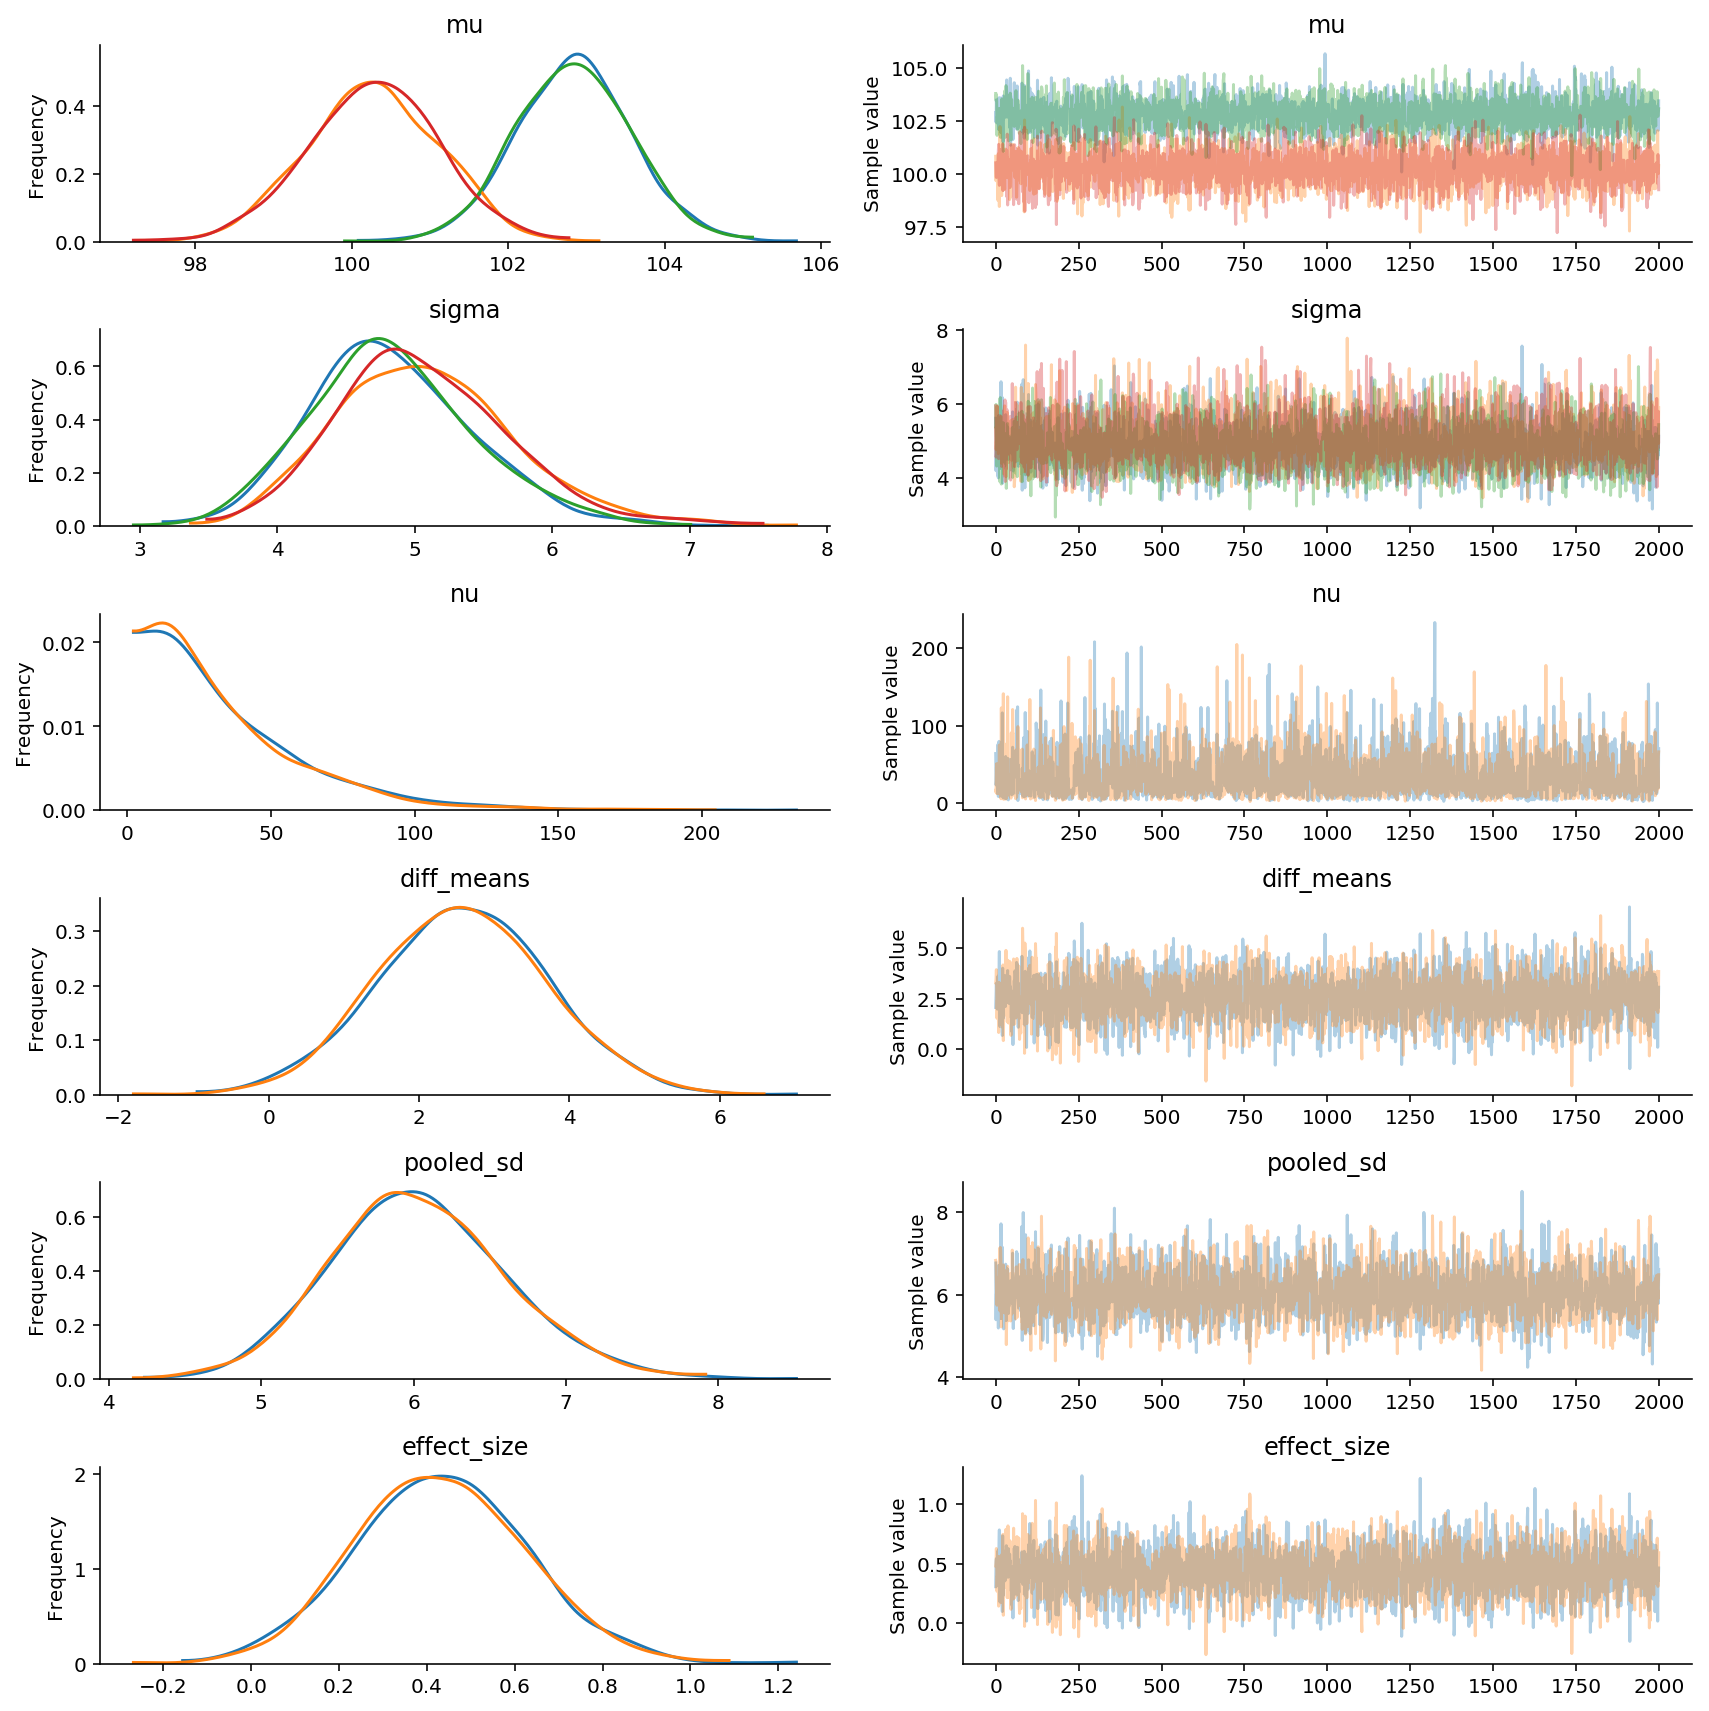

In [18]:
traces = pm.traceplot(trace_alt)

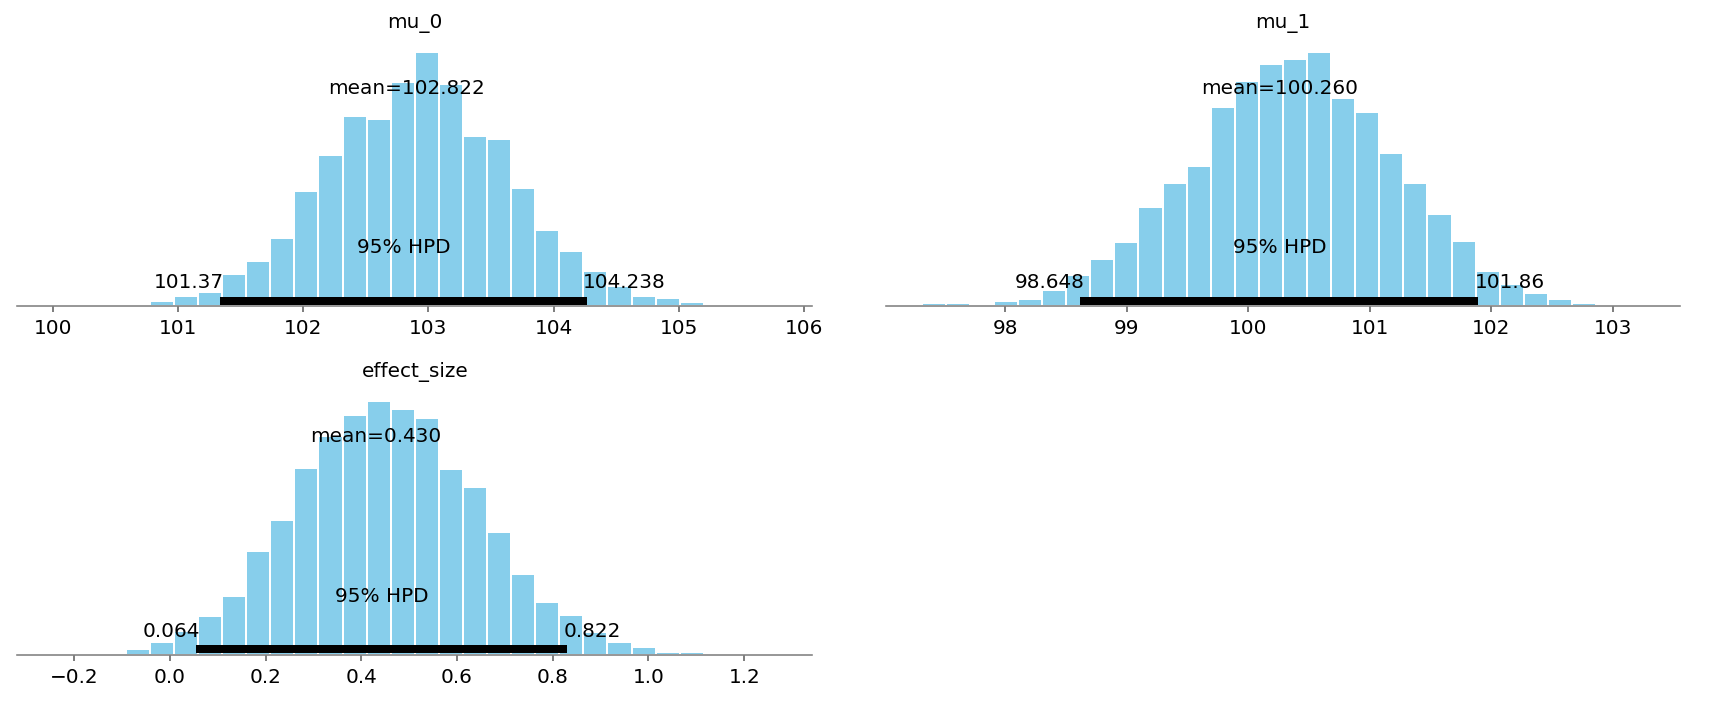

In [19]:
pm.plot_posterior(trace_alt, varnames=['mu', 'effect_size']);

# Case study
# Two group comparison - Darwin's Finches

In [20]:
import pandas as pd
import janitor as jn
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import ECDF

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Darwin's Finches

A research group has taken measurements of the descendants of the finches that Charles Darwin observed when he postulated the theory of evolution.

We will be using Bayesian methods to analyze this data, specifically answering the question of how quantitatively different two species of birds' beaks are.

## Data Credits

The Darwin's finches datasets come from the paper, [40 years of evolution. Darwin's finches on Daphne Major Island][data]. 

One row of data has been added for pedagogical purposes.

[data]: (https://datadryad.org/resource/doi:10.5061/dryad.g6g3h). 

Let's get started and load the data.

In [21]:
from data import load_finches_2012
df = load_finches_2012()

**Exercise:** View a random sample of the data to get a feel for the structure of the dataset.

In [22]:
df.sample(5)

,band,species,beak_length,beak_depth,species_enc
68,19889,fortis,10.0,8.4,0
157,19495,scandens,13.4,9.5,1
85,21087,fortis,12.9,9.9,0
238,21288,scandens,14.1,10.0,1
90,21160,fortis,10.2,8.4,0


**Note:** I have added one row of data, simulating the discovery of an "unknown" species of finch for which beak measurements have been taken.

For pedagogical brevity, we will analyze only beak depth during the class. However, I would encourage you to perform a similar analysis for beak length as well.

In [23]:
# These are filters that we can use later on.
fortis_filter = df['species'] == 'fortis'
scandens_filter = df['species'] == 'scandens'
unknown_filter = df['species'] == 'unknown'

**Exercise:** Recreate the estimation model for finch beak depths. A few things to note:

- Practice using numpy-like fancy indexing.
- Difference of means & effect size are optional.
- Feel free to play around with other priors.

A visual representation of the model using distribution diagrams is as follows:

![](../images/darwins-finches-model.jpg)

In [24]:
with pm.Model() as beak_depth_model:
    # Beaks cannot be of "negative" mean, therefore, HalfNormal is 
    # a reasonable, constrained prior.
    mean = pm.HalfNormal('mean', sd=100, shape=(3,))
    # Define the prior for the observed variance of the beak depths
    sd = pm.HalfCauchy('sd', beta=100, shape=(3,))
    # Define the nuisance parameter nu for the T distribution
    nu = pm.Exponential('nu', lam=1/29.) + 1
    
    # Define the likelihood.
    like = pm.StudentT('likelihood', 
                       nu=nu,
                       mu=mean[df['species_enc']], 
                       sd=sd[df['species_enc']], 
                       observed=df['beak_depth'])

**Exercise:** Perform MCMC sampling to estimate the posterior distribution of each parameter.

In [25]:
with beak_depth_model:
    trace = pm.sample(2000, tuning=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sd, mean]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:41<00:00, 121.74draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


**Exercise:** Diagnose whether the sampling has converged or not using trace plots.

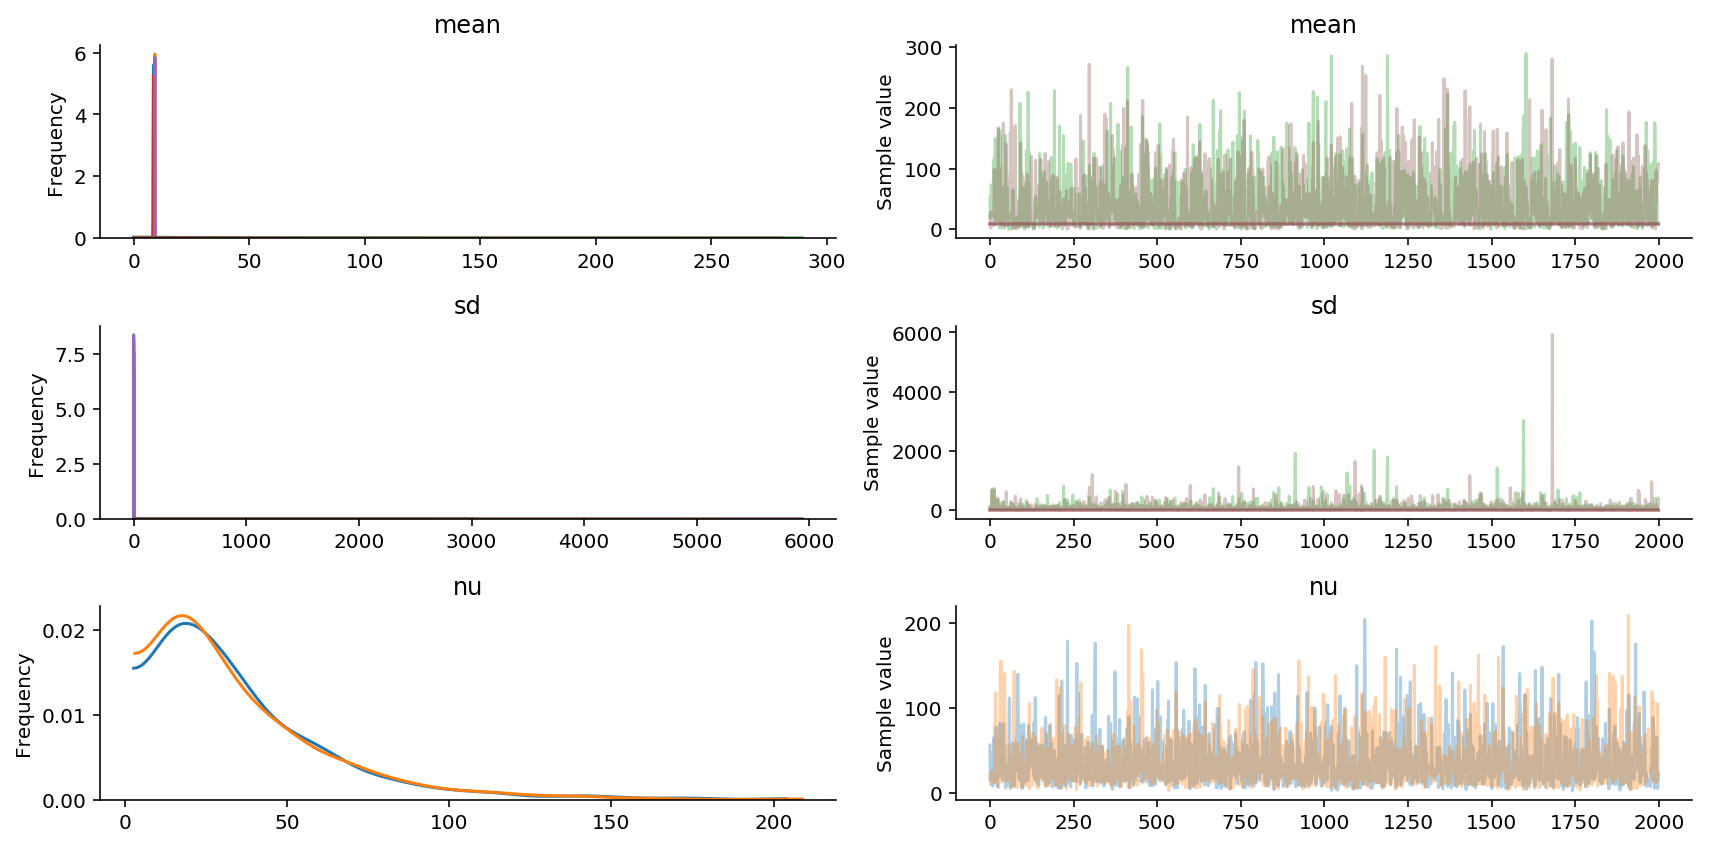

In [26]:
traces = pm.traceplot(trace)

**Exercise:** Visualize the posterior distribution over the parameters using the forest plot.

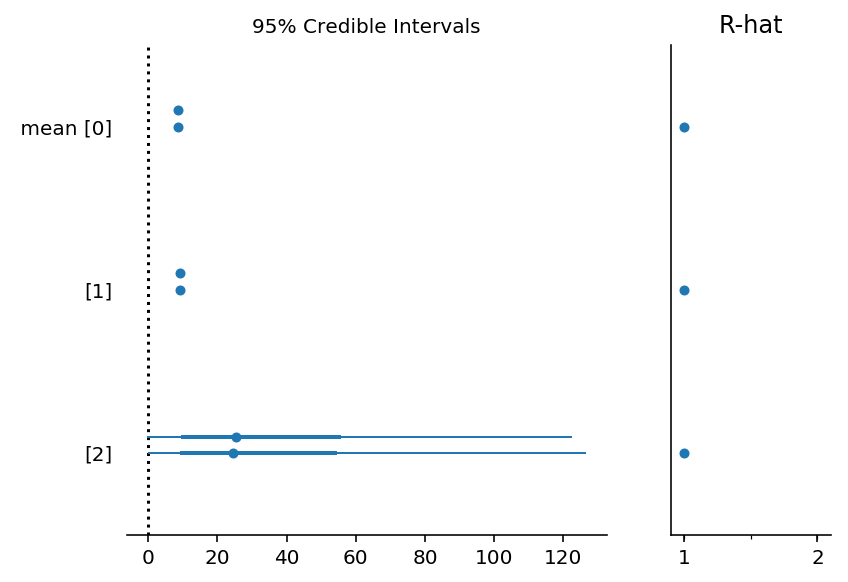

In [27]:
pm.forestplot(trace, varnames=['mean']);

**Exercise:** Visualize the posterior distribution of the means using `plot_posterior`.

Text(0.5,1,'unknown')

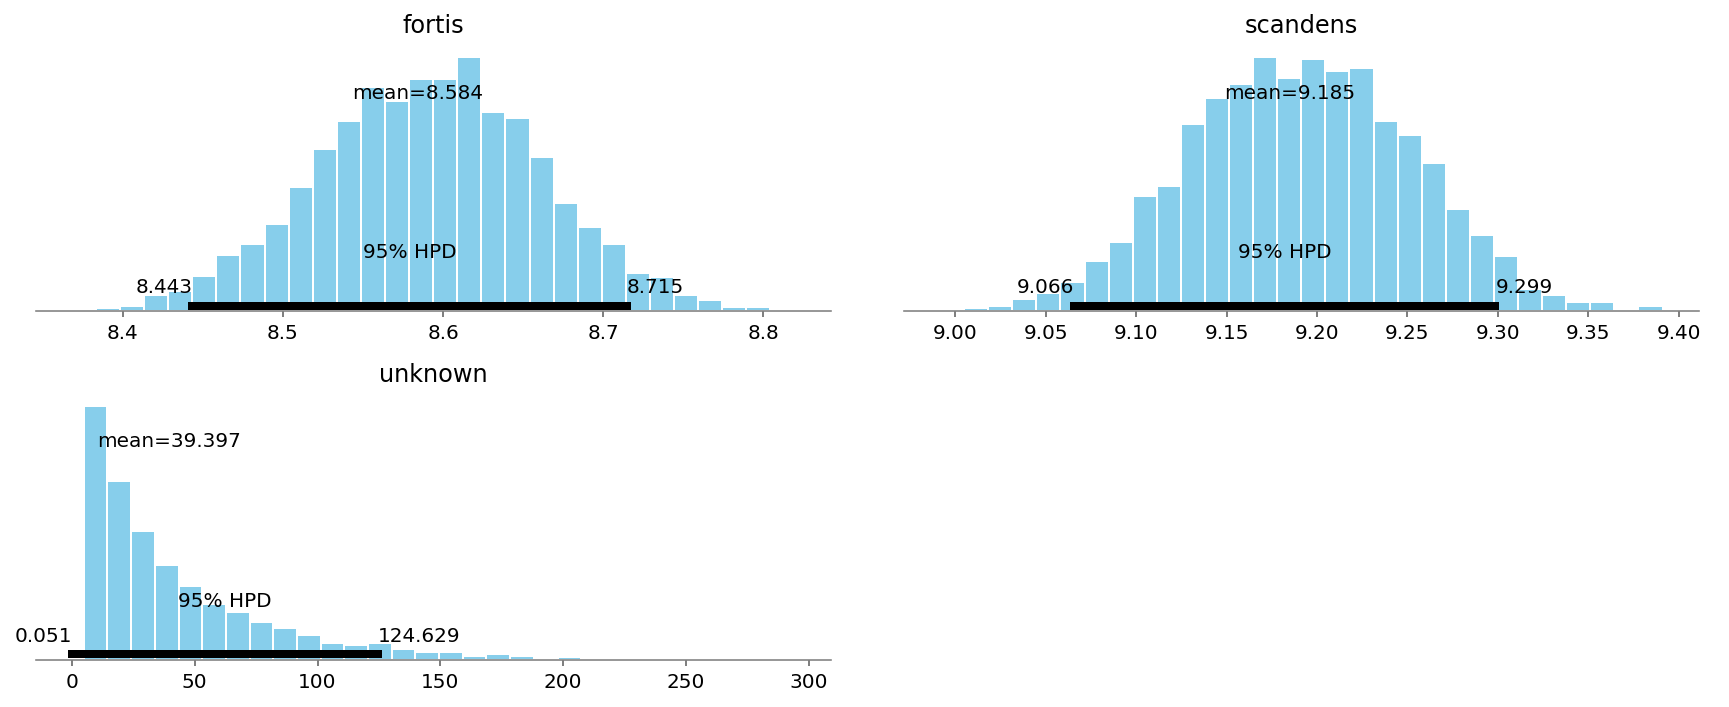

In [28]:
ax1, ax2, ax3 = pm.plot_posterior(trace, varnames=['mean'])
ax1.set_title('fortis')
ax2.set_title('scandens')
ax3.set_title('unknown')

**Discuss:**
- Is the posterior distribution of beaks for the unknown species reasonable?

**Exercise:** Perform a posterior predictive check to visually diagnose whether the model describes the data generating process well or not.

In [29]:
samples = pm.sample_ppc(trace, model=beak_depth_model, samples=2000)

100%|██████████| 2000/2000 [00:02<00:00, 707.51it/s]


Hint: Each column in the samples (key: "likelihood") corresponds to simulated measurements of each finch in the dataset. We can use fancy indexing along the columns (axis 1) to select out simulated measurements for each category, and then flatten the resultant array to get the full estimated distribution of values for each class.

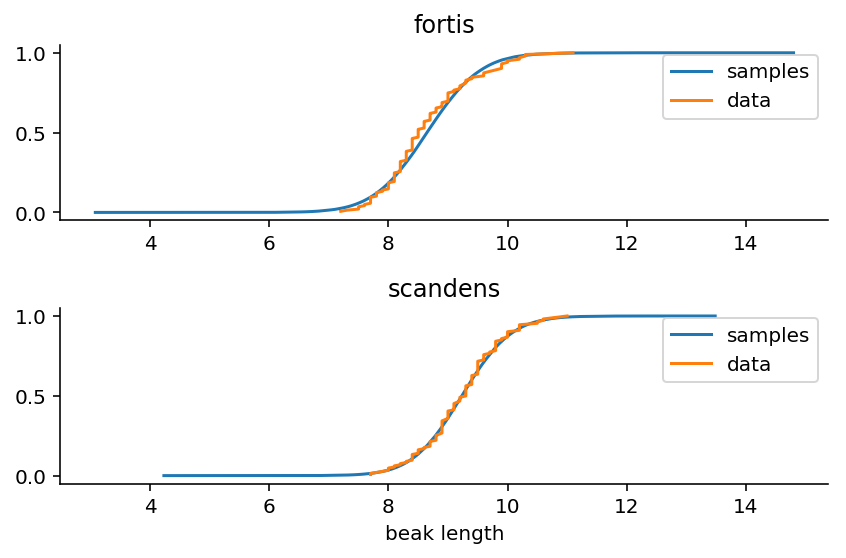

In [30]:
fig = plt.figure()
ax_fortis = fig.add_subplot(2, 1, 1)
ax_scandens = fig.add_subplot(2, 1, 2, sharex=ax_fortis)

# Extract just the fortis samples.
fortis_samples = samples['likelihood'][:, df[fortis_filter].index].flatten()
# Compute the ECDF for the fortis samples.
x_s, y_s = ECDF(fortis_samples)
ax_fortis.plot(x_s, y_s, label='samples')

# Extract just the fortis measurements.
fortis_data = df[fortis_filter]['beak_depth']
# Compute the ECDF for the fortis samples
x, y = ECDF(fortis_data)
ax_fortis.plot(x, y, label='data')

ax_fortis.legend()
ax_fortis.set_title('fortis')

# Extract just the scandens samples.
scandens_samples = samples['likelihood'][:, df[scandens_filter].index].flatten()
# Compute the ECDF for the scandens samples
x_s, y_s = ECDF(scandens_samples)
ax_scandens.plot(x_s, y_s, label='samples')

# Extract just the scandens measurements.
scandens_data = df[scandens_filter]['beak_depth']
# Compute the ECDF for the scanens samples
x, y = ECDF(scandens_data)

ax_scandens.plot(x, y, label='data')
ax_scandens.legend()
ax_scandens.set_title('scandens')
ax_scandens.set_xlabel('beak length')

plt.tight_layout()

## Summary

1. NumPy-like fancy indexing lets us write models in a concise fashion.
1. Posterior estimates can show up as being "unreasonable", "absurd", or at the minimum, counter-intuitive, if we do not impose the right set of assumptions on the model.


# Multi-group comparison

In [31]:
import pymc3 as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import theano.tensor as tt
from utils import ECDF

%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Setup

You will be experimentally analyzing the effectiveness of six different phone sterilization methods against two control methods. This research was conducted at MIT's Division of Comparative Medicine, and was published this year in the Journal of the American Association for Laboratory Animal Science. If you're interested, you can read the paper [here][jaalas].

[jaalas]: https://www.ncbi.nlm.nih.gov/pubmed/29402348

### Experiment Design

Briefly, the experiments were setup as such.

1. Pre-sterilization, three sites on the phone were swabbed and the number of colony forming units (CFUs) was determined by letting the swabbed bacteria grow on an agar plate.
1. Post-sterilization, the same three sites were swabbed and the number of CFUs was counted.
1. Sterilization efficacy was determined by taking the ratio of the difference of CFUs pre- and post-sterilization.

In the paper, we used the following formula to compute the percentage reduction:

$$\delta_{method} = \frac{{count}_{pre} - {count}_{post}}{{count}_{pre}}$$

In retrospect, a better definition would have been:

$$x = \frac{{count}_{pre} - {count}_{post}}{{count}_{pre}}$$
$$\delta_{method} = \begin{cases}
    0 & \text{if} & x\lt0, \\
    1 & \text{if} & x\gt1, \\
    x & \text{otherwise}
    \end{cases}$$

Sometimes, due to experimental variation, there are more colonies post-sterilization than pre-sterilization. This may occur particularly when the number of colonies counted on a plate is low (e.g. countable on our fingers). Thus, clipping the values helps us avoid negative percentage reductions, which one might consider to be be an "absurd" scenario to be in.

### Data

The data for this notebook came from [Evaluation of 6 Methods for Aerobic Bacterial Sanitization of Smartphones](https://www.ncbi.nlm.nih.gov/pubmed/29402348).

### Step 1: Define Data Generating Process

Just as in the previous notebook, you may want to spend 5-10 minutes talking through the data generating process before proceeding. Most important is to list out the distributions that you think are most relevant to the problem.

### Step 2: Explore the Data

Let's load the data. Here is the source code for the `load_sterilization` function, which will return the cleaned data as a pandas dataframe, as well as a mapping dictionary that we will use later to label groups.

In [32]:
from data import load_sterilization

load_sterilization??

Signature: load_sterilization()
Docstring: <no docstring>
Source:   
def load_sterilization():
    df = pd.read_csv('../data/sterilization.csv', na_filter=True, na_values=['#DIV/0!'])
    df = jn.DataFrame(df).clean_names().label_encode('treatment')
    mapping = dict(zip(df['treatment'], df['treatment_enc']))
    return df, mapping
File:      ~/Documents/GitHub/bayesian-stats-modelling-tutorial/notebooks/data.py
Type:      function


In [33]:
df, mapping = load_sterilization()

In [34]:
df.sample(5)

,sample_id,treatment,colonies_pre,colonies_post,perc_reduction_colonies,morphologies_pre,morphologies_post,year,month,day,perc_reduction_morph,site,phone_id,no_case,screen_protector,treatment_enc
50,51,kimwipe,27,0,100.000000,4,0,2016.0,5.0,10.0,100.000000,case,19,NaN,NaN,5
168,169,cellblaster,25,9,64.000000,6,4,NaN,NaN,NaN,33.333333,junction,14,NaN,NaN,3
131,132,CB30,50,1,98.000000,4,1,NaN,NaN,NaN,75.000000,phone,3,NaN,NaN,0
145,146,CB30,12,6,50.000000,3,3,NaN,NaN,NaN,0.000000,case,51,NaN,NaN,0
51,52,kimwipe,7,1,85.714286,2,1,NaN,NaN,NaN,50.000000,phone,19,NaN,NaN,5


**Exercise:** To help you visualize what data are available and missing in the dataframe, run the cell below to get a visual matrix (using MissingNo). (By the way, be sure to make use of this awesome tool in your data analysis!)

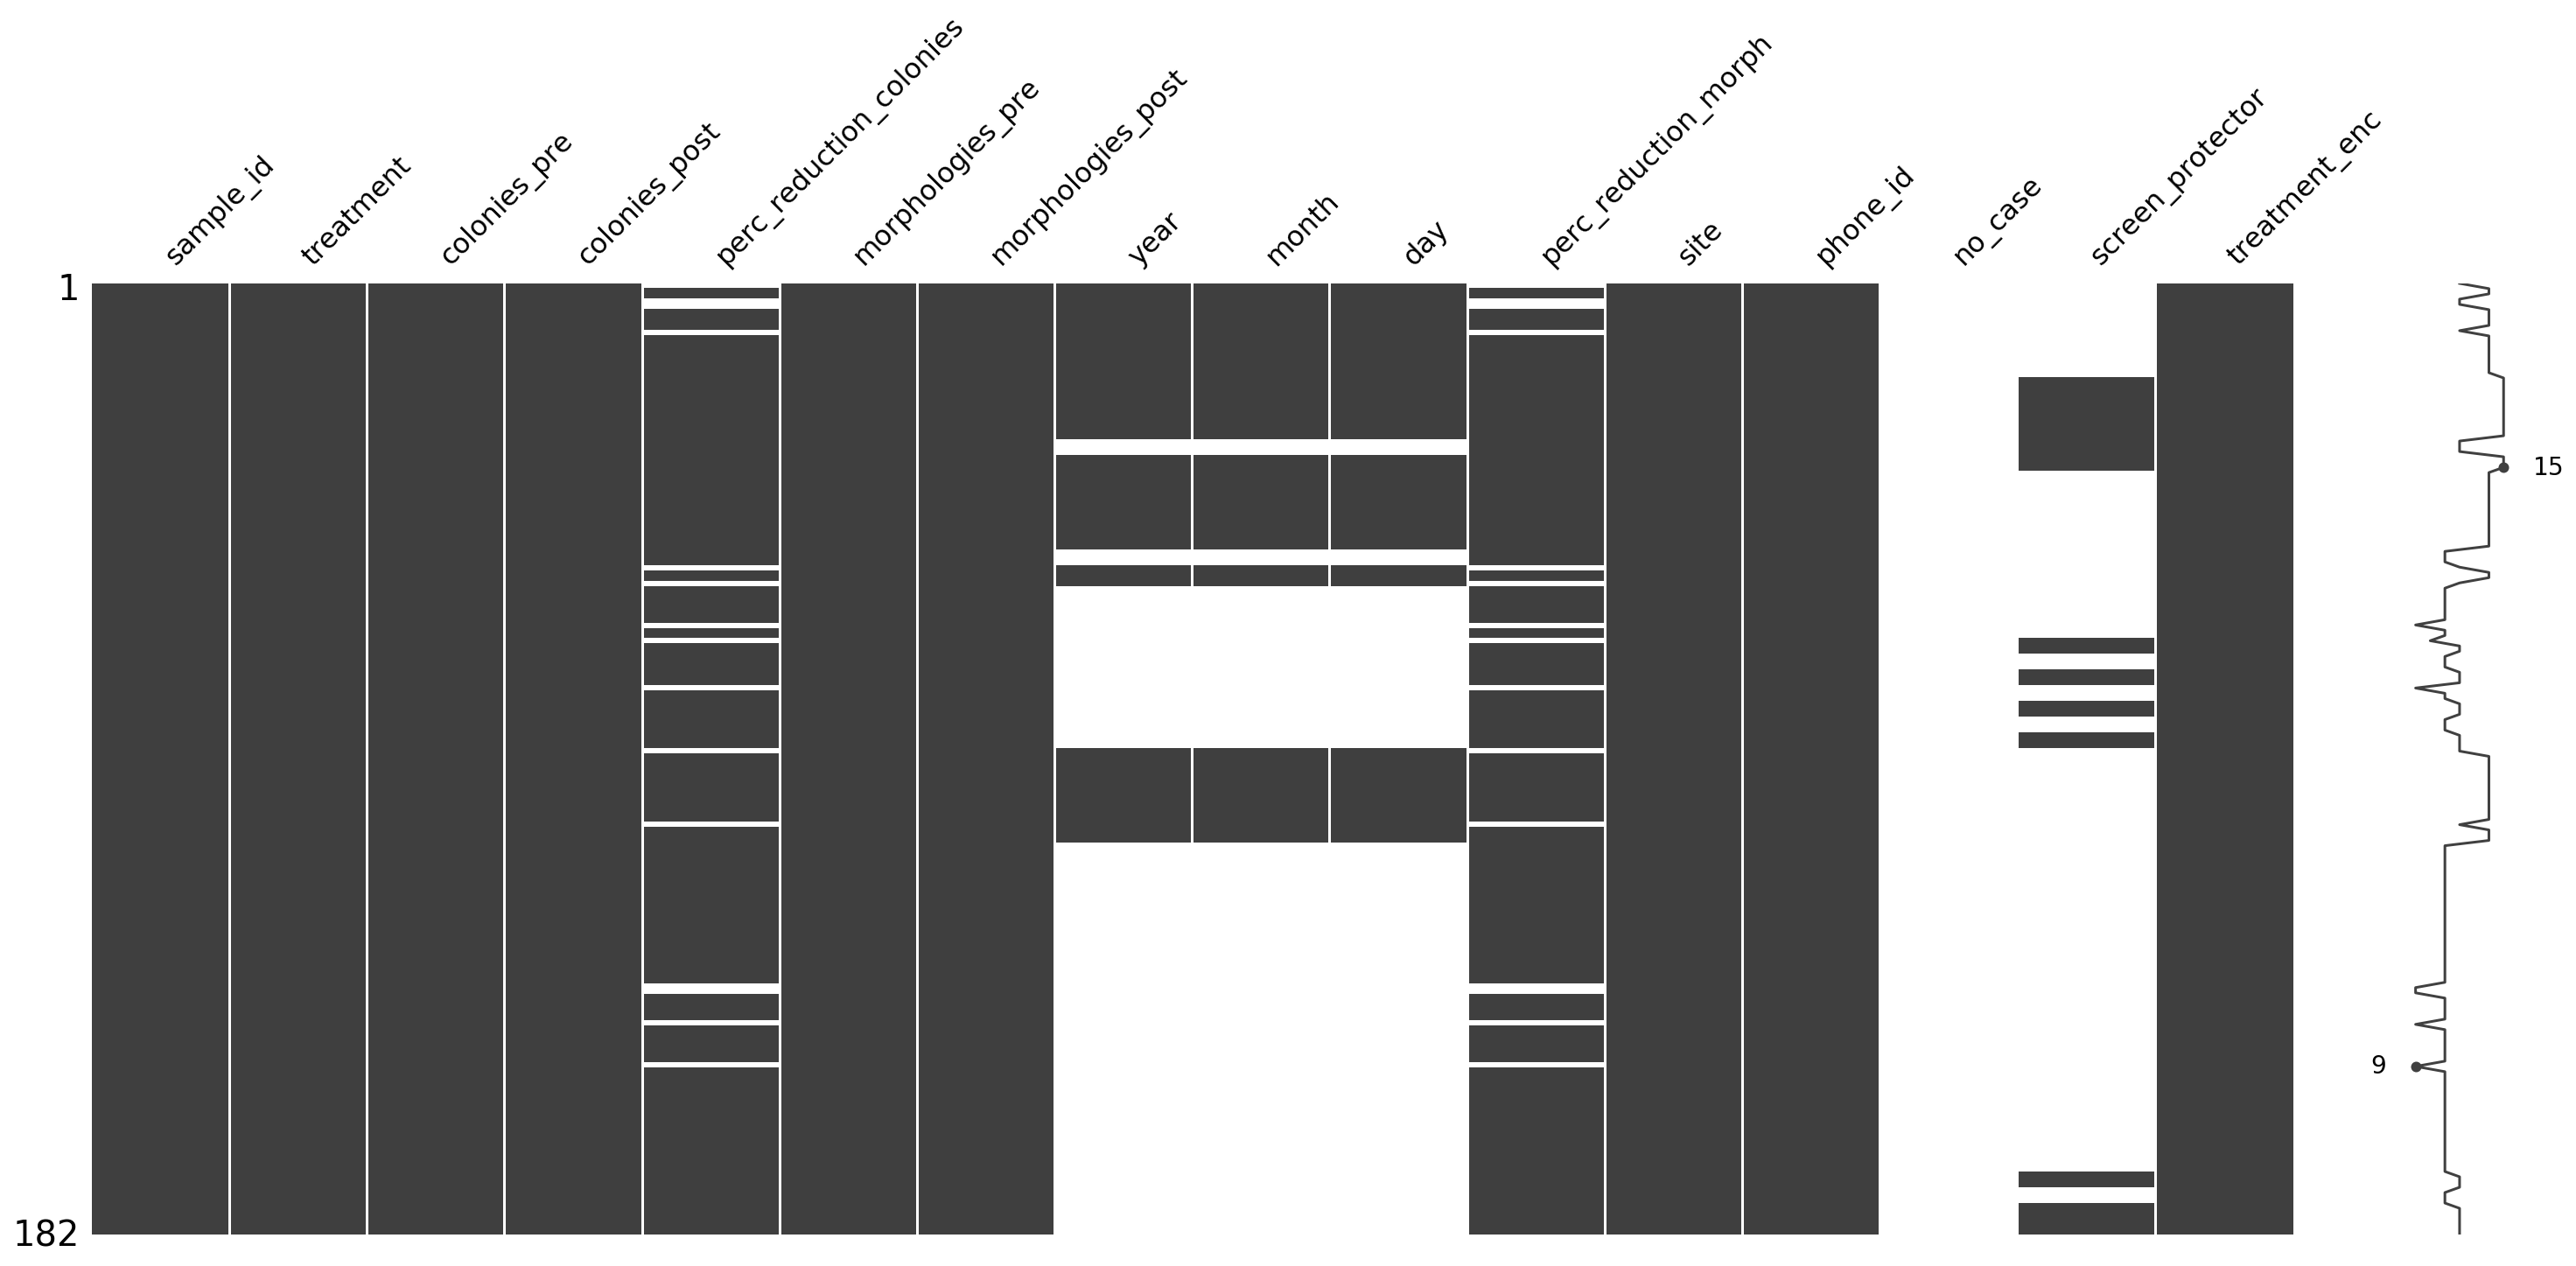

In [35]:
# Run this cell, no coding required.
msno.matrix(df);

**Exercise:** Plot the average percentage reduction in colonies for each treatment.

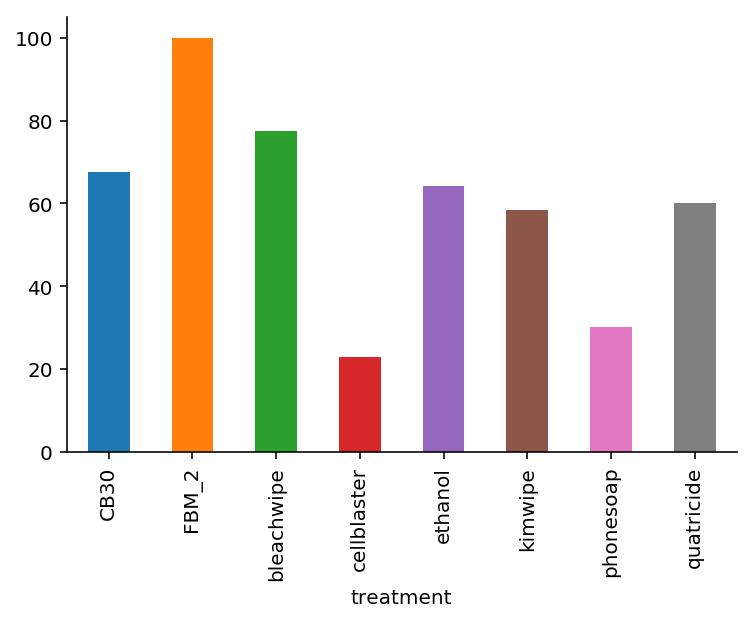

In [36]:
df.groupby('treatment').mean()['perc_reduction_colonies'].plot(kind='bar');

### Step 3: Implement and Fit Model

**Exercise:** Write the generative model for the data. 

To help you, this is a diagrammed version of the model below.

![](../images/bacteria_model.jpg)

In [37]:
# Implement the model following the hints provided.
with pm.Model() as model:
    
    # Define an exponential distribution: it is positive-only, which fits our assumptions of the
    # data. Also, we choose a lam parameter that allows the prior to be flat.
    # Remember that there are 8 treatments, so the shape of these distributions must be set correctly.
    mu_pre = pm.Exponential('mu_pre', lam=5, shape=len(df['treatment'].unique()))
    mu_post = pm.Exponential('mu_post', lam=5, shape=len(df['treatment'].unique()))
    
    # Define the likelihoods using Poisson distributions.
    like_pre = pm.Poisson('like_pre', mu=mu_pre[df['treatment_enc']], observed=df['colonies_pre'])
    like_post = pm.Poisson('like_post', mu=mu_post[df['treatment_enc']], observed=df['colonies_post'])
    
    # Compute percentage reduction
    # hint: tt.clip performs the exact same operation as 
    # np.clip, which bounds your values between 0 and 1.
    perc_reduction = pm.Deterministic('perc_reduction', tt.clip((mu_pre - mu_post) / mu_pre, 0, 1))

Now, sample from the posterior!

In [38]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_post, mu_pre]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:12<00:00, 395.28draws/s]


Check the traces to make sure that sampling has converged.

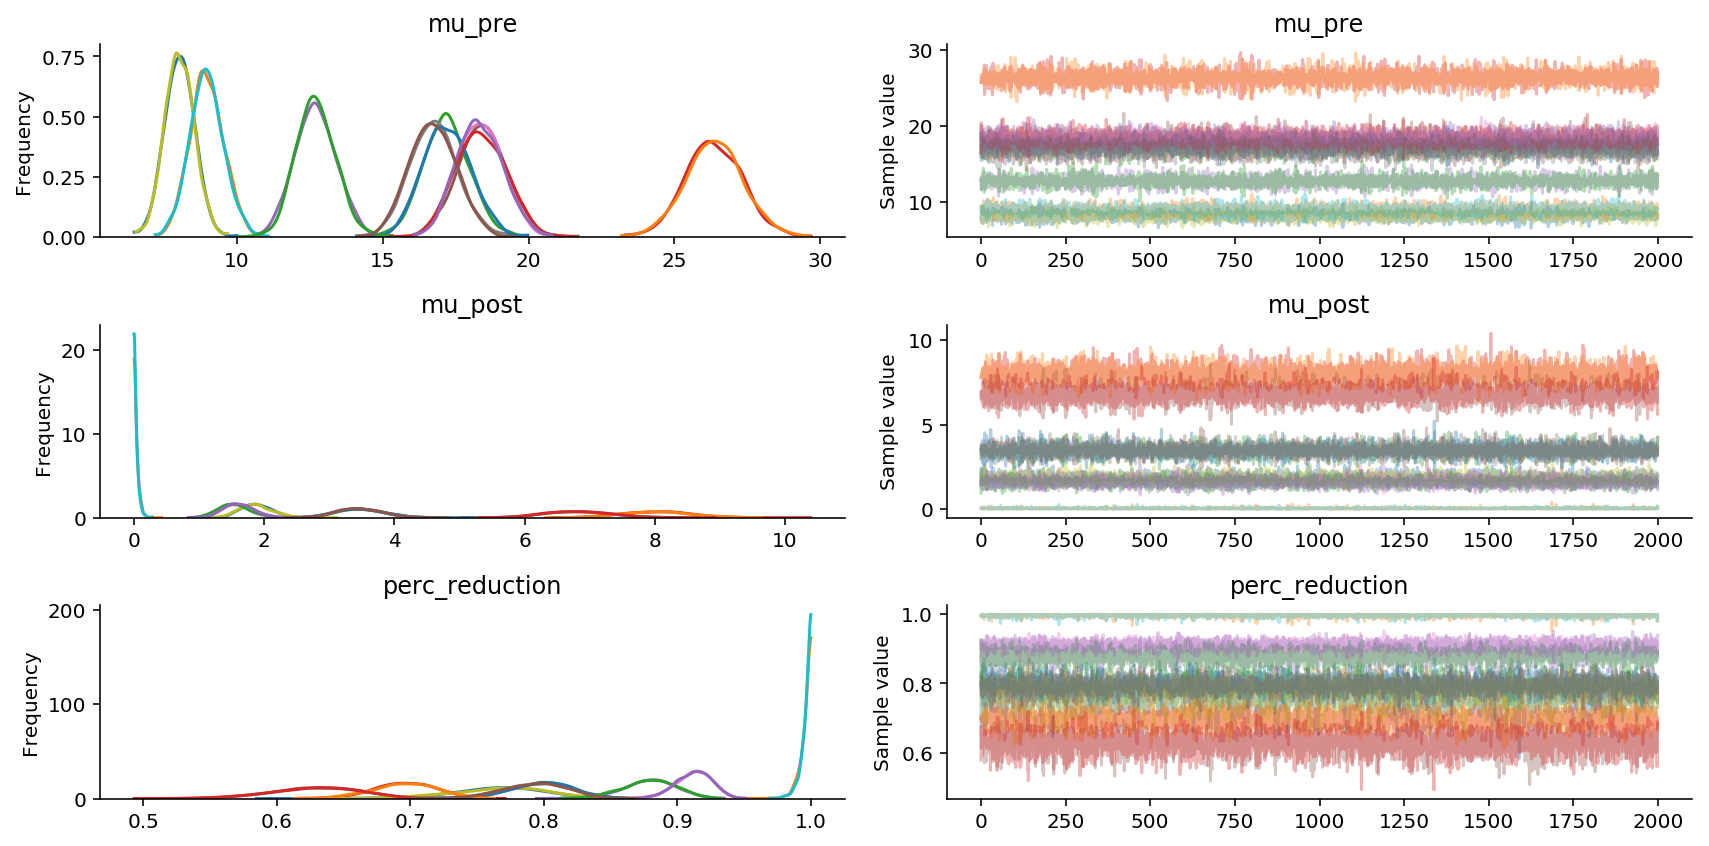

In [39]:
# Plot the trace plots.
pm.traceplot(trace);

Visualize the posterior distributions of percentage reduction

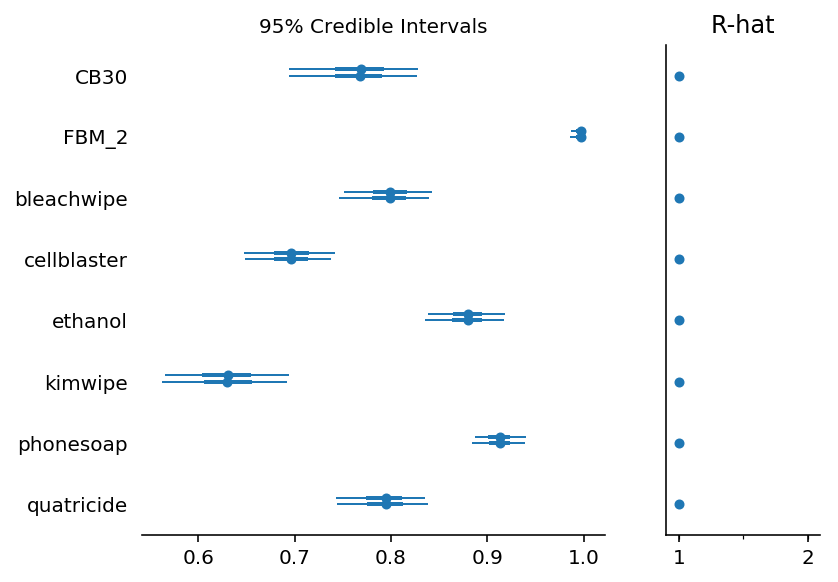

In [40]:
pm.forestplot(trace, varnames=['perc_reduction'], ylabels=sorted(mapping));

**Discussion:** Find a neighbour who is working on the same notebook, and discuss this together.

- Which method of sterilization is the most effective? 
- Observe the posterior distribution. Is there any uncertainty surrounding this method's effectiveness? Could we still be wrong about the uncertainty?

# Summary

- Two-group (and multi-group) comparisons involve a Bayesian estimation procedure.
- We estimate parameter of interest for each group, and then compare the parameter posterior distributions.